# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from sklearn.model_selection import train_test_split
from numpy.random import RandomState
import time
!/opt/conda/bin/python -m pip install wordcloud
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, ImageColorGenerator
!pip install --upgrade Pillow

from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
data.drop(data.columns[0], axis= 1 , inplace= True ) #удалим столбец Unnamed: 0

In [6]:
data.head() #проверим

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


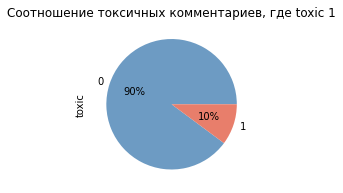

In [7]:
data['toxic'].value_counts().plot(
    kind = 'pie',
    autopct='%1.0f%%',
    figsize=(3,3),
    colors= ['#6d9bc3', '#e87e6b'],
    title = 'Соотношение токсичных комментариев, где toxic 1');

Пропуски отсутствуют. Токсичные комментарии составляют около 10%.

----

**Проведем очистку и лемматизацию текста**

In [8]:
l = WordNetLemmatizer() #лемматизатор

In [9]:
stopwords = set(nltk_stopwords.words('english')) #стопслова

In [10]:
def clean(text):
    text = text.lower()
    text = ' '.join(re.sub(r'[^a-zA-Z ]', ' ', text).split()) 
    text = text.replace('\n', '')
    return text

In [11]:
def lemmatize(text, stopwords = stopwords):
    tokens = nltk.word_tokenize(text)
    return ' '.join([l.lemmatize(token) for token in tokens if token not in stopwords])

In [12]:
corpus = []
for comment in data['text']: 
    corpus.append(lemmatize(clean(comment)))

In [13]:
corpus #проверим


['explanation edits made username hardcore metallica fan reverted vandalism closure gas voted new york doll fac please remove template talk page since retired',
 'aww match background colour seemingly stuck thanks talk january utc',
 'hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info',
 'make real suggestion improvement wondered section statistic later subsection type accident think reference may need tidying exact format ie date format etc later one else first preference formatting style reference want please let know appears backlog article review guess may delay reviewer turn listed relevant form eg wikipedia good article nomination transport',
 'sir hero chance remember page',
 'congratulation well use tool well talk',
 'cocksucker piss around work',
 'vandalism matt shirvington article reverted please banned',
 'sorry word nonsense offensive anyway intending write anything article wow would

Посмотрим на частоту встречающихся слов

In [14]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud, interpolation="bilinear") 
    plt.axis("off")

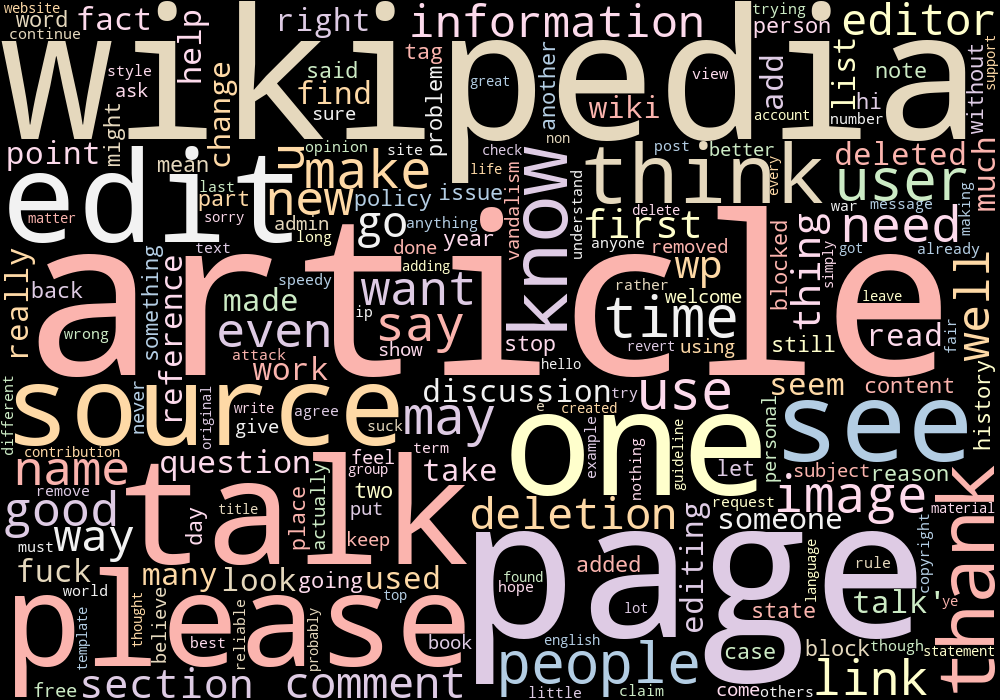

In [15]:
corp = str(corpus)
wordcloud = WordCloud(width = 1000, 
                      height = 700, 
                      random_state=1, 
                      background_color='black',
                      colormap='Pastel1', 
                      collocations=False).generate(corp)
wordcloud.to_image()

In [16]:
features = corpus
target = data['toxic'] #признаки и целевой признак

In [17]:
state = np.random.RandomState(12345) #зафиксируем random_state

**Разделим данные на обучающую, валидационную и тестовую выборки**

In [18]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.4, random_state = state)

In [19]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size = 0.5, random_state = state)

In [20]:
count_tf_idf = TfidfVectorizer()
features_train = count_tf_idf.fit_transform(features_train)
features_valid = count_tf_idf.transform(features_valid)
features_test = count_tf_idf.transform(features_test)
#функцию fit() запускаем только на обучающей

----

**Напишем функции для времени обучения и предсказания, F1**

In [21]:
def learning_time(model, features_train,target_train):
    start = time.time()
    model.fit(features_train,target_train)
    end = time.time()
    time_fit = end - start
    return time_fit,model #время обучения

In [22]:
def predicted_time(model,features_valid):
    start = time.time()
    predict = model.predict(features_valid)
    end = time.time()
    time_predict= end - start
    return time_predict,predict #время предсказания

In [23]:
results = pd.DataFrame(columns=['Время обучения', 'Время предсказания', 'F1', 'Модель']) 
#результаты работы моделей

In [24]:
def table_results(learn_time, pred_time, f1, model, df):
    df.loc[model,'Время обучения'] = learn_time
    df.loc[model,'Время предсказания'] = pred_time
    df.loc[model,'F1'] = f1
    df.loc[model,'Модель'] = model
    return df

## Обучение

**LogisticRegression**

In [25]:
lr_learn_time,lr = learning_time(LogisticRegression(random_state=state, solver='liblinear', 
                                                    class_weight='balanced', C=8), 
                                 features_train, target_train)
lr_pred_time,lr_predict = predicted_time(lr,features_valid)
lr_f1 = f1_score(target_valid, lr_predict).round(4)
table_results(lr_learn_time,lr_pred_time, lr_f1, 'LogisticRegression',results)

,Время обучения,Время предсказания,F1,Модель
LogisticRegression,23.682129,0.004004,0.7637,LogisticRegression


**RandomForestClassifier**

In [26]:
rfc_learn_time,rfc = learning_time(RandomForestClassifier(random_state=state, class_weight='balanced', 
                                                          n_estimators=70, max_depth=19, min_samples_leaf=3), 
                                   features_train, target_train)
rfc_pred_time,rfc_predict = predicted_time(rfc,features_valid)
rfc_f1 = f1_score(target_valid, rfc_predict).round(4)
table_results(rfc_learn_time,rfc_pred_time, rfc_f1, 'RandomForestClassifier',results)

,Время обучения,Время предсказания,F1,Модель
LogisticRegression,23.682129,0.004004,0.7637,LogisticRegression
RandomForestClassifier,3.3397,0.431579,0.3967,RandomForestClassifier


**DecisionTreeClassifier**

In [27]:
dtc_learn_time,dtc = learning_time(DecisionTreeClassifier(random_state=state, class_weight = 'balanced', 
                                                          max_depth=40),
                                    features_train, target_train)
dtc_pred_time,dtc_predict = predicted_time(dtc,features_valid)
dtc_f1 = f1_score(target_valid, dtc_predict).round(4)
table_results(dtc_learn_time,dtc_pred_time, dtc_f1, 'DecisionTreeClassifier',results)

,Время обучения,Время предсказания,F1,Модель
LogisticRegression,23.682129,0.004004,0.7637,LogisticRegression
RandomForestClassifier,3.3397,0.431579,0.3967,RandomForestClassifier
DecisionTreeClassifier,26.767687,0.010117,0.6142,DecisionTreeClassifier


**CatBoostClassifier**

In [30]:
cbc_learn_time,cbc = learning_time(CatBoostClassifier(iterations=130, learning_rate=0.3, verbose=13),
                                    features_train, target_train)
cbc_pred_time,cbc_predict = predicted_time(cbc,features_valid)
cbc_f1 = f1_score(target_valid, cbc_predict).round(4)
table_results(cbc_learn_time,cbc_pred_time, cbc_f1, 'CatBoostClassifier',results)

0:	learn: 0.4393847	total: 2.68s	remaining: 5m 46s
13:	learn: 0.1904751	total: 28.1s	remaining: 3m 52s
26:	learn: 0.1690767	total: 52.7s	remaining: 3m 21s
39:	learn: 0.1560447	total: 1m 17s	remaining: 2m 53s
52:	learn: 0.1470506	total: 1m 41s	remaining: 2m 27s
65:	learn: 0.1403373	total: 2m 5s	remaining: 2m 1s
78:	learn: 0.1349604	total: 2m 29s	remaining: 1m 36s
91:	learn: 0.1302348	total: 2m 53s	remaining: 1m 11s
104:	learn: 0.1267695	total: 3m 16s	remaining: 46.9s
117:	learn: 0.1234832	total: 3m 40s	remaining: 22.4s
129:	learn: 0.1203528	total: 4m 2s	remaining: 0us


,Время обучения,Время предсказания,F1,Модель
LogisticRegression,23.682129,0.004004,0.7637,LogisticRegression
RandomForestClassifier,3.3397,0.431579,0.3967,RandomForestClassifier
DecisionTreeClassifier,26.767687,0.010117,0.6142,DecisionTreeClassifier
CatBoostClassifier,268.857971,0.301553,0.7373,CatBoostClassifier


<div style="border:solid steelblue 2px; padding: 10px; border-radius: 5px">
Наилучший показатель F1 0.7637 у модели LogisticRegression.

### Тестирование

**Проверим модель LogisticRegression на тестовой выборке**

In [31]:
model_lr = LogisticRegression(random_state=state, solver='liblinear', class_weight='balanced', C=8)
model_lr.fit(features_train, target_train)
predicted_lr = model_lr.predict(features_test)
print('Значение F1 модели LogisticRegression на тестовой выборке:', f1_score(target_test, predicted_lr).round(4))

Значение F1 модели LogisticRegression на тестовой выборке: 0.7628


**Проверим модель на адекватность**

In [32]:
dummy = DummyClassifier(strategy='uniform', random_state = state)
dummy.fit(features_train, target_train)
predicted_dummy = dummy.predict(features_test)
print('Значение F1 константной модели:', f1_score(target_test,predicted_dummy).round(4))

Значение F1 константной модели: 0.1689


## Вывод

<div class="alert-info" style="padding: 20px; border-radius: 10px">
Пропуски в данных отсутствуют. Токсичные комметарии составляют около 10%.<br>  
Проведена очистка и лемматизация текста.
    
Были обучены следующие модели с показателями F1: 
- LogisticRegression          0.7637 
- RandomForestClassifier      0.3967 
- DecisionTreeClassifier	  0.6142
- CatBoostClassifier          0.7373
    
    
Наилучший показатель F1 0.7637 у модели LogisticRegression.<br>
Значение F1 модели LogisticRegression на тестовой выборке: 0.7628.

Модель прошла оценку на адекватность, метрика F1 не менее 0.75 достигнута.
    
    

    